<a href="https://colab.research.google.com/github/danya-codit/DZZ/blob/main/model_json.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install segmentation_models_pytorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 20.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 27.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 24.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 59.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalli

In [3]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
import numpy as np
from PIL import Image
import json
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight
from pycocotools import mask as maskUtils
import os
import segmentation_models_pytorch as smp
from google.colab import drive
from tqdm.notebook import tqdm
import matplotlib.patches as mpatches

In [4]:
# 1. Монтирование Google Drive и настройка путей
drive.mount('/content/drive')
IMAGE_PATH = '/content/drive/MyDrive/Цифровая кафедра/Сигментация/supervisely/full_area_01.png'
ANNOTATION_PATH = '/content/drive/MyDrive/Цифровая кафедра/Сигментация/supervisely/instances.json'
SAVE_DIR = '/content/drive/MyDrive/Цифровая кафедра/Сигментация/supervisely/models/'
os.makedirs(SAVE_DIR, exist_ok=True)

# 2. Конфигурация классов и цветов
CLASSES = ['background', 'city', 'field', 'forest', 'water']
CLASS_COLORS = {
    1: [255, 0, 0],    # Красный - город
    2: [255, 255, 0],  # Желтый - поле
    3: [0, 255, 0],    # Зеленый - лес
    4: [0, 0, 255]     # Синий - вода
}
NUM_CLASSES = len(CLASSES)
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

Mounted at /content/drive


In [5]:
# 3. Класс Dataset
class SatelliteDataset(Dataset):
    def __init__(self, image_path, annotation_path, transform=None):
        self.image = np.array(Image.open(image_path).convert('RGB'))
        with open(annotation_path) as f:
            self.coco_data = json.load(f)
        self.transform = transform
        self.masks = self._load_masks()

    def _load_masks(self):
        h, w = self.image.shape[:2]
        mask = np.zeros((h, w), dtype=np.uint8)

        for ann in self.coco_data['annotations']:
            if isinstance(ann['segmentation'], list):
                if len(ann['segmentation']) > 0:
                    rle = maskUtils.frPyObjects(ann['segmentation'], h, w)
                    m = maskUtils.decode(rle)
                    if m.ndim == 3:
                        m = np.sum(m, axis=2) > 0
            elif isinstance(ann['segmentation'], dict):
                m = maskUtils.decode(ann['segmentation'])
            else:
                continue

            mask[m > 0] = ann['category_id']

        return mask

    def __len__(self):
        return 100  # 100 аугментированных вариантов

    def __getitem__(self, idx):
        if self.transform:
            transformed = self.transform(image=self.image, mask=self.masks)
            return transformed['image'], transformed['mask']
        return self.image, self.masks

# 4. Аугментации
def get_transform():
    return A.Compose([
        A.RandomCrop(512, 512),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomRotate90(p=0.5),
        A.RandomBrightnessContrast(p=0.2),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2()
    ])

# 5. Модель
class SegModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = smp.Unet(
            encoder_name="resnet34",
            encoder_weights="imagenet",
            classes=NUM_CLASSES,
            activation='softmax'
        )

    def forward(self, x):
        return self.model(x)

# 6. Веса классов
def get_class_weights(mask):
    present_classes = np.unique(mask)
    weights = compute_class_weight(
        'balanced',
        classes=present_classes,
        y=mask.flatten()
    )
    weight_dict = {cls: weight for cls, weight in zip(present_classes, weights)}
    return torch.tensor([weight_dict.get(i, 1.0) for i in range(NUM_CLASSES)]).float().to(DEVICE)

# 7. Функция IoU
def calculate_iou(preds, targets):
    smooth = 1e-6
    preds = torch.argmax(preds, dim=1)
    intersection = (preds == targets).float().sum()
    union = (preds != 0).float().sum() + (targets != 0).float().sum() - intersection
    return (intersection + smooth) / (union + smooth)

# 8. Обучение с прогресс-баром
def train(num_epochs=20):
    dataset = SatelliteDataset(IMAGE_PATH, ANNOTATION_PATH, get_transform())
    loader = DataLoader(dataset, batch_size=4, shuffle=True)

    model = SegModel().to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    weights = get_class_weights(dataset.masks)
    criterion = nn.CrossEntropyLoss(weight=weights)

    train_loss = []
    train_iou = []
    best_iou = 0.0

    # Обучение с прогресс-баром
    epoch_pbar = tqdm(range(num_epochs), desc='Обучение', unit='epoch')
    for epoch in epoch_pbar:
        model.train()
        epoch_loss = 0
        epoch_iou = 0

        batch_pbar = tqdm(loader, desc=f'Эпоха {epoch+1}', leave=False)
        for images, masks in batch_pbar:
            images, masks = images.to(DEVICE), masks.to(DEVICE)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks.long())
            loss.backward()
            optimizer.step()

            with torch.no_grad():
                batch_iou = calculate_iou(outputs, masks)
                epoch_loss += loss.item()
                epoch_iou += batch_iou

            batch_pbar.set_postfix({
                'Loss': f'{loss.item():.4f}',
                'IoU': f'{batch_iou:.4f}'
            })

        epoch_loss /= len(loader)
        epoch_iou /= len(loader)
        train_loss.append(epoch_loss)
        train_iou.append(epoch_iou)

        if epoch_iou > best_iou:
            best_iou = epoch_iou
            torch.save(model.state_dict(), os.path.join(SAVE_DIR, 'best_model.pth'))
            epoch_pbar.set_postfix({'Best IoU': f'{best_iou:.4f}'})

    torch.save(model.state_dict(), os.path.join(SAVE_DIR, 'final_model.pth'))

    # Графики
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_loss, 'r-', label='Loss')
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(train_iou, 'g-', label='IoU')
    plt.title('Training IoU')
    plt.xlabel('Epoch')
    plt.grid(True)

    plt.tight_layout()
    plt.savefig(os.path.join(SAVE_DIR, 'training_metrics.png'), dpi=300)
    plt.show()

    return model

# 9. Визуализация предсказаний
def predict_and_visualize(model, image_path):
    model.eval()
    image = np.array(Image.open(image_path).convert('RGB'))
    h, w = image.shape[:2]

    transform = A.Compose([
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2()
    ])

    full_mask = np.zeros((h, w), dtype=np.uint8)
    tile_size = 512

    with tqdm(total=(h//tile_size)*(w//tile_size), desc='Обработка изображения') as pbar:
        for y in range(0, h, tile_size):
            for x in range(0, w, tile_size):
                tile = image[y:y+tile_size, x:x+tile_size]
                if tile.size == 0:
                    continue

                transformed = transform(image=tile)
                tile_tensor = transformed['image'].unsqueeze(0).to(DEVICE)

                with torch.no_grad():
                    output = model(tile_tensor)
                    pred = torch.argmax(output, dim=1).cpu().numpy()[0]

                full_mask[y:y+tile.shape[0], x:x+tile.shape[1]] = pred
                pbar.update(1)

    color_mask = np.zeros((h, w, 3), dtype=np.uint8)
    for class_id, color in CLASS_COLORS.items():
        color_mask[full_mask == class_id] = color

    plt.figure(figsize=(18, 6))
    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.title('Исходное изображение')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(color_mask)
    plt.title('Предсказанная маска')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(image)
    plt.imshow(color_mask, alpha=0.5)
    plt.title('Наложение маски')
    plt.axis('off')

    patches = [mpatches.Patch(color=np.array(color)/255, label=CLASSES[class_id])
               for class_id, color in CLASS_COLORS.items()]
    plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    plt.show()

In [9]:
# 10. Запуск
if __name__ == "__main__":
    print("Начало обучения...")
    NUM_EPOCHS = 30 # Можно изменить
    trained_model = train(num_epochs=NUM_EPOCHS)

    print("\nТестирование модели:")
    TEST_IMAGE = '/content/drive/MyDrive/Цифровая кафедра/Сигментация/supervisely/full_area_02.png'
    predict_and_visualize(trained_model, TEST_IMAGE)

Начало обучения...


KeyboardInterrupt: 

Dropdown(description='Категория:', index=2, options=('Лес', 'Поле', 'Город', 'Вода'), style=DescriptionStyle(d…

IntSlider(value=10, description='Количество:', max=20, min=1, style=SliderStyle(description_width='initial'))

FloatSlider(value=0.5, description='Прозрачность:', max=1.0, min=0.1, style=SliderStyle(description_width='ini…

Button(button_style='success', description='Запуск!', layout=Layout(width='200px'), style=ButtonStyle())

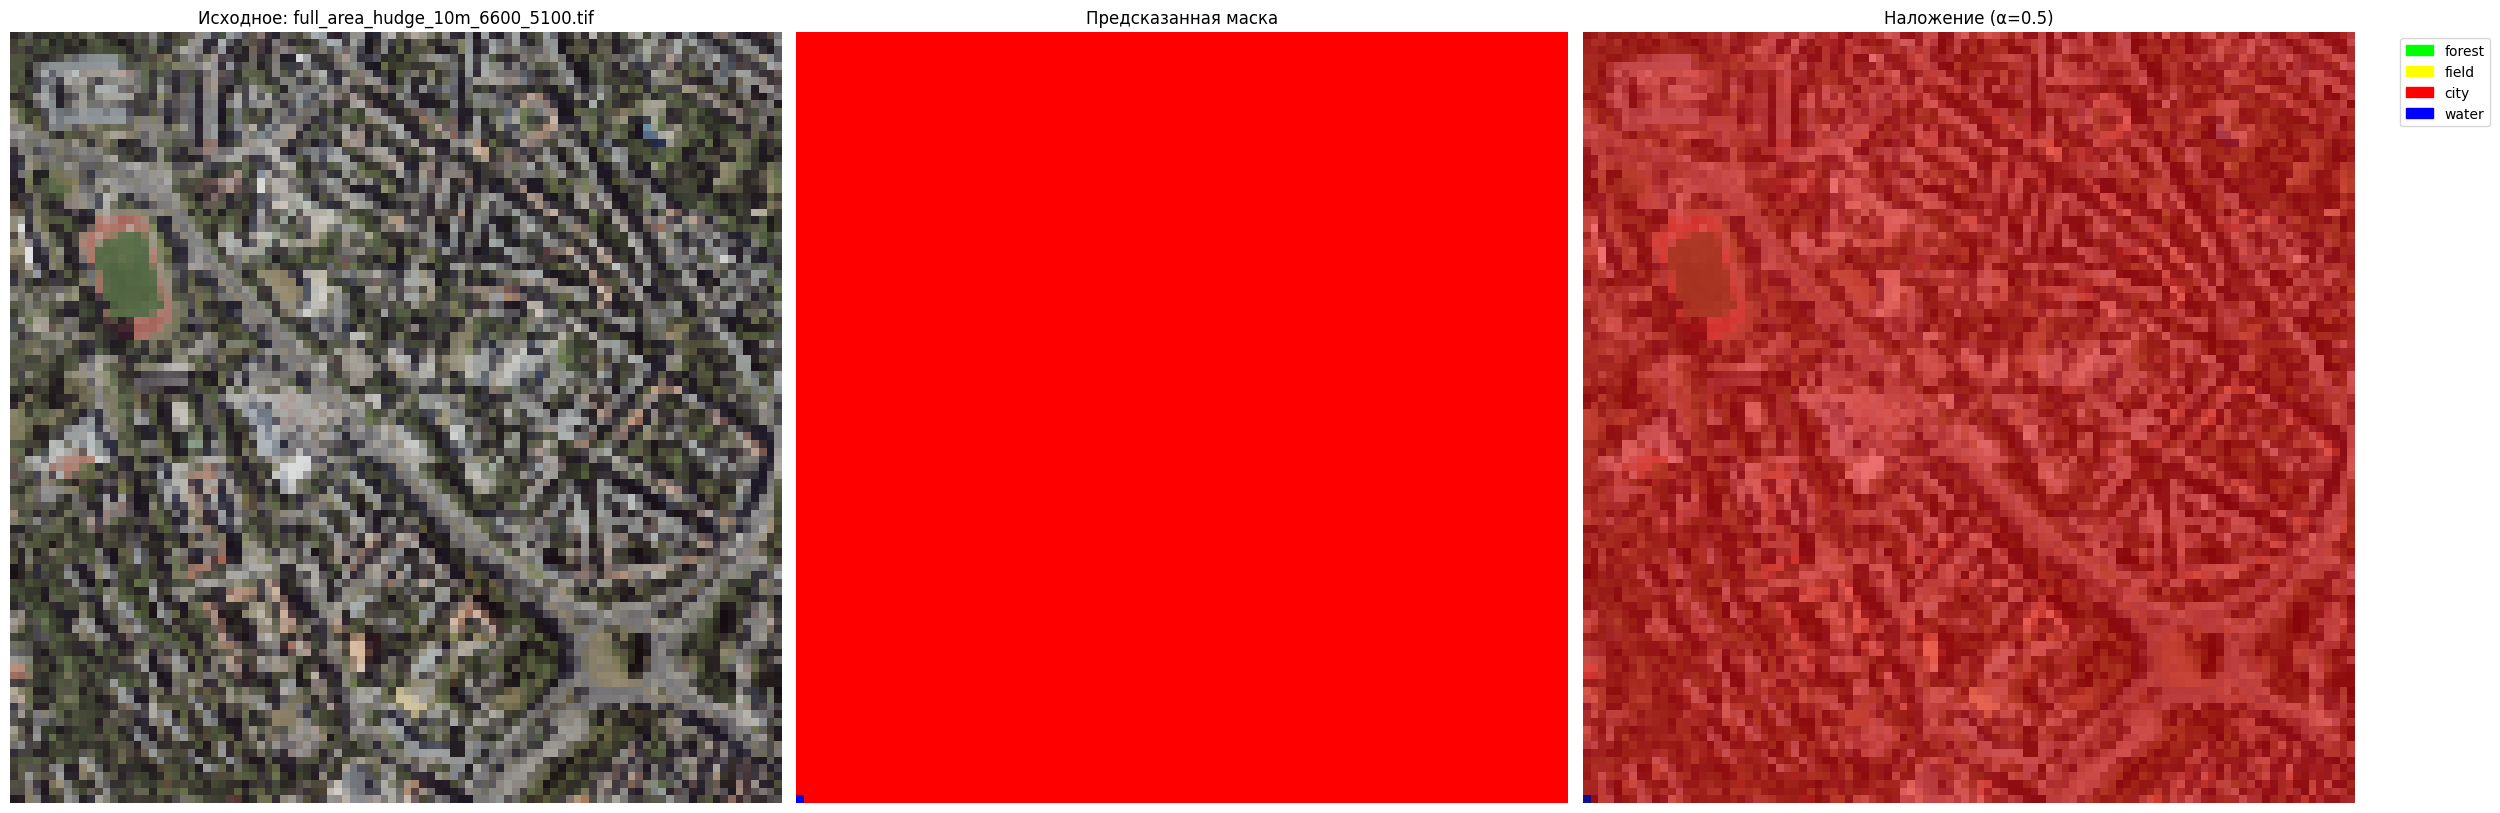


Файл: /content/drive/MyDrive/Цифровая кафедра/Сигментация/Полный архив/Город/full_area_hudge_10m_6600_5100.tif
city: 99.99%
water: 0.01%
--------------------------------------------------


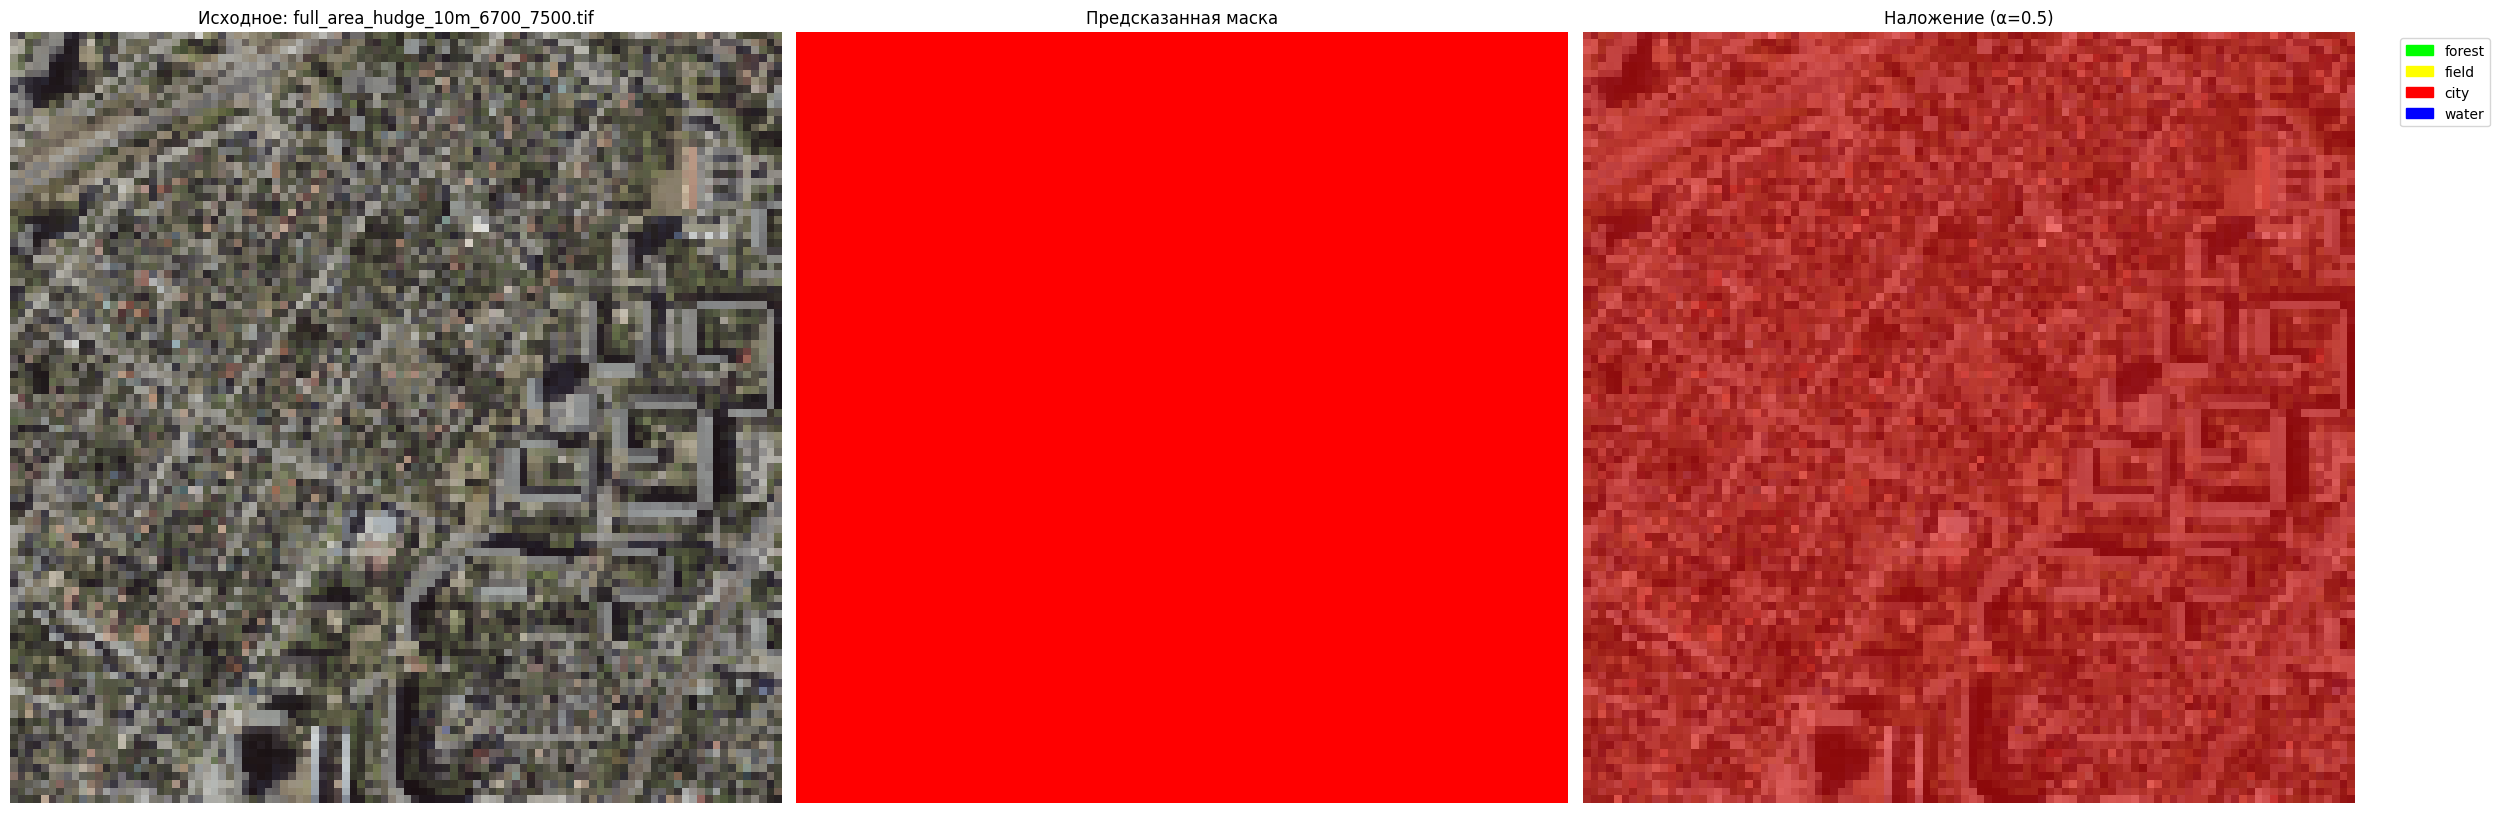


Файл: /content/drive/MyDrive/Цифровая кафедра/Сигментация/Полный архив/Город/full_area_hudge_10m_6700_7500.tif
city: 100.00%
--------------------------------------------------


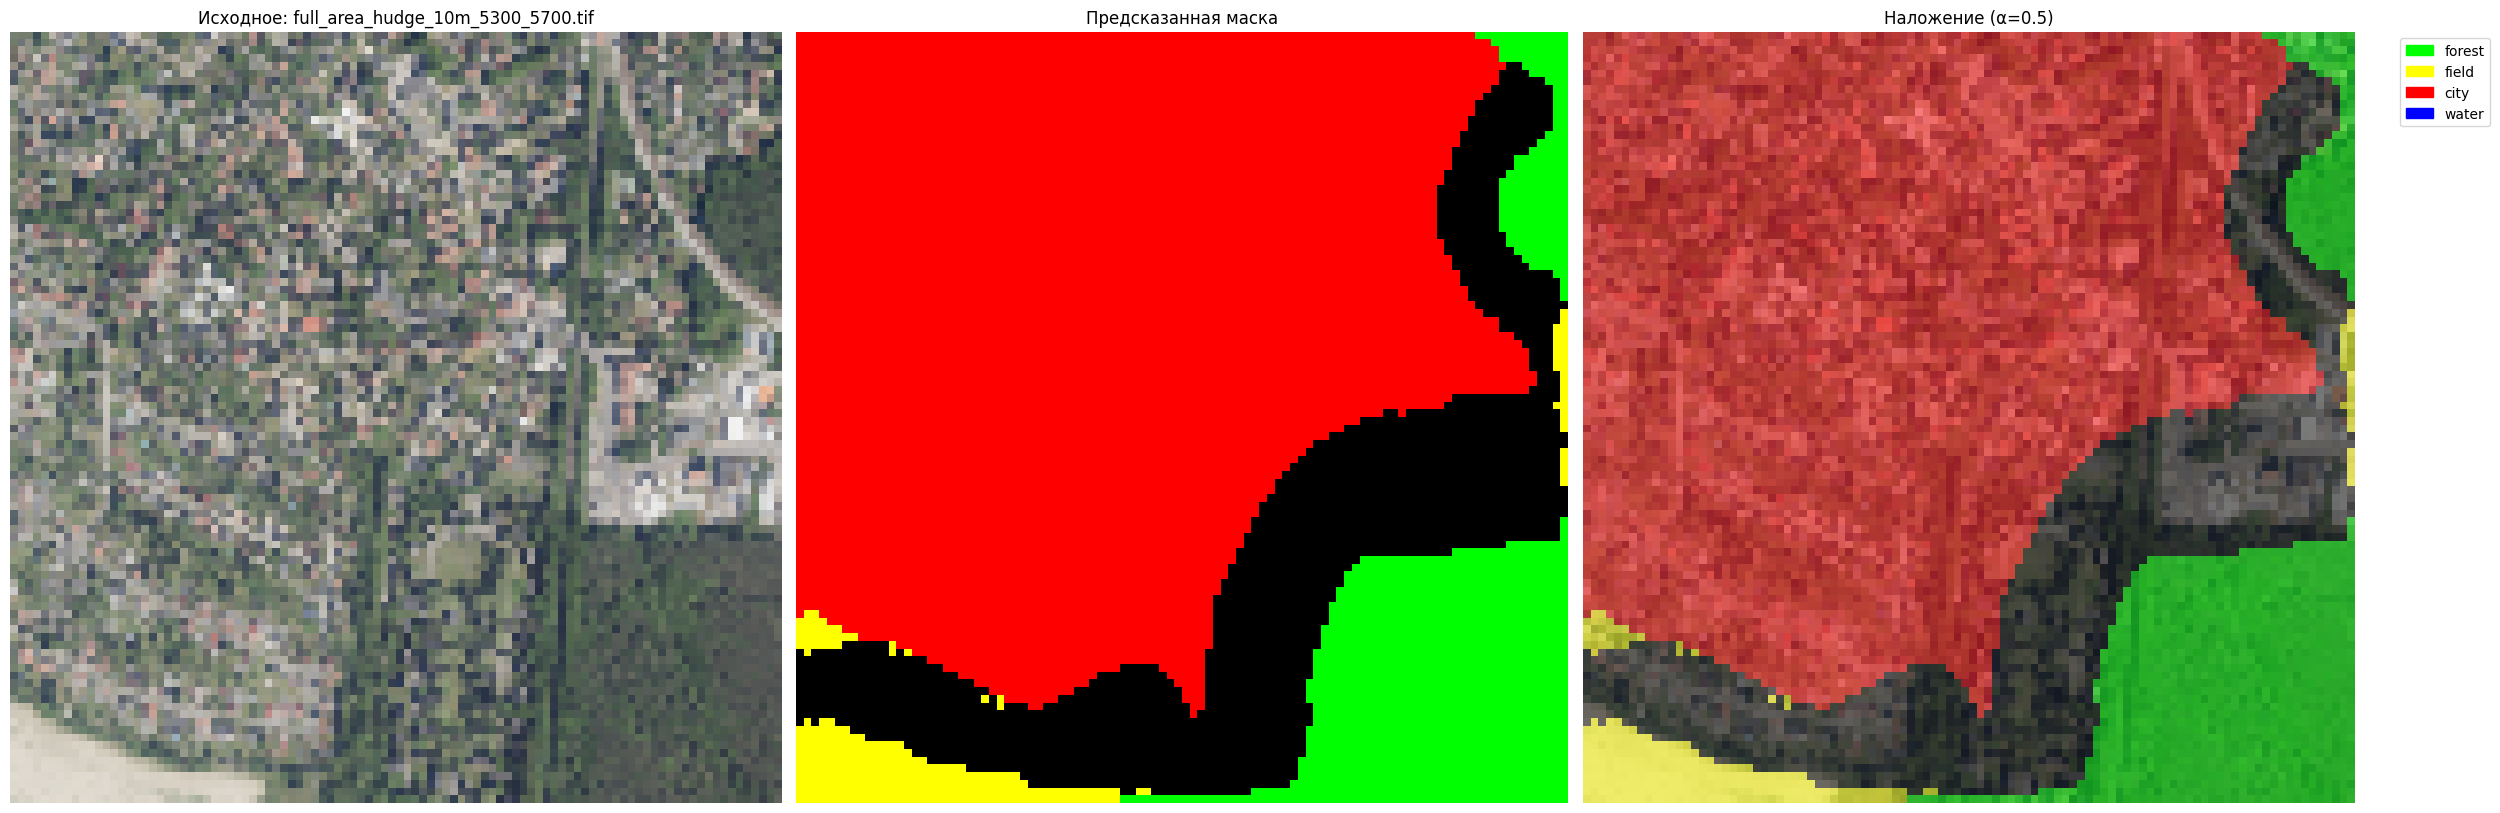


Файл: /content/drive/MyDrive/Цифровая кафедра/Сигментация/Полный архив/Город/full_area_hudge_10m_5300_5700.tif
background: 20.89%
forest: 12.99%
field: 2.93%
city: 63.19%
--------------------------------------------------


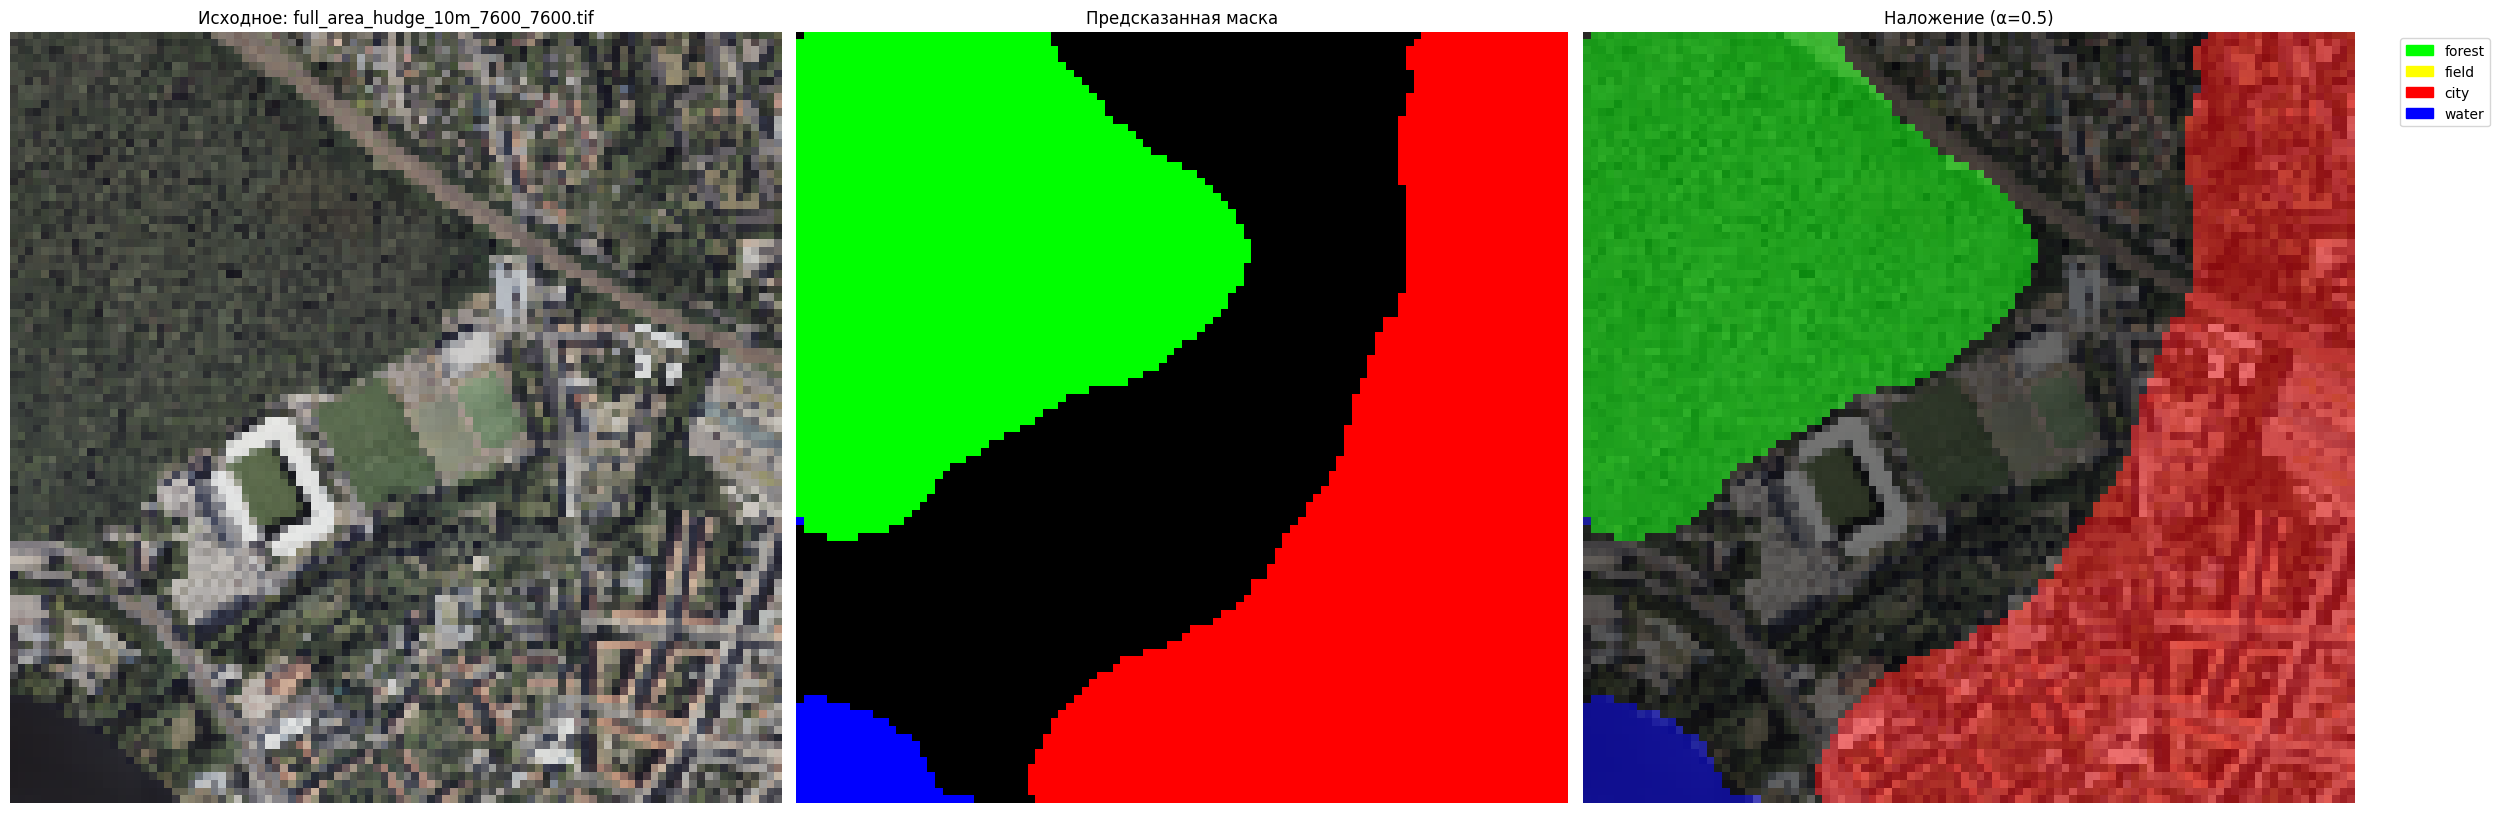


Файл: /content/drive/MyDrive/Цифровая кафедра/Сигментация/Полный архив/Город/full_area_hudge_10m_7600_7600.tif
background: 35.77%
forest: 26.79%
city: 35.39%
water: 2.05%
--------------------------------------------------


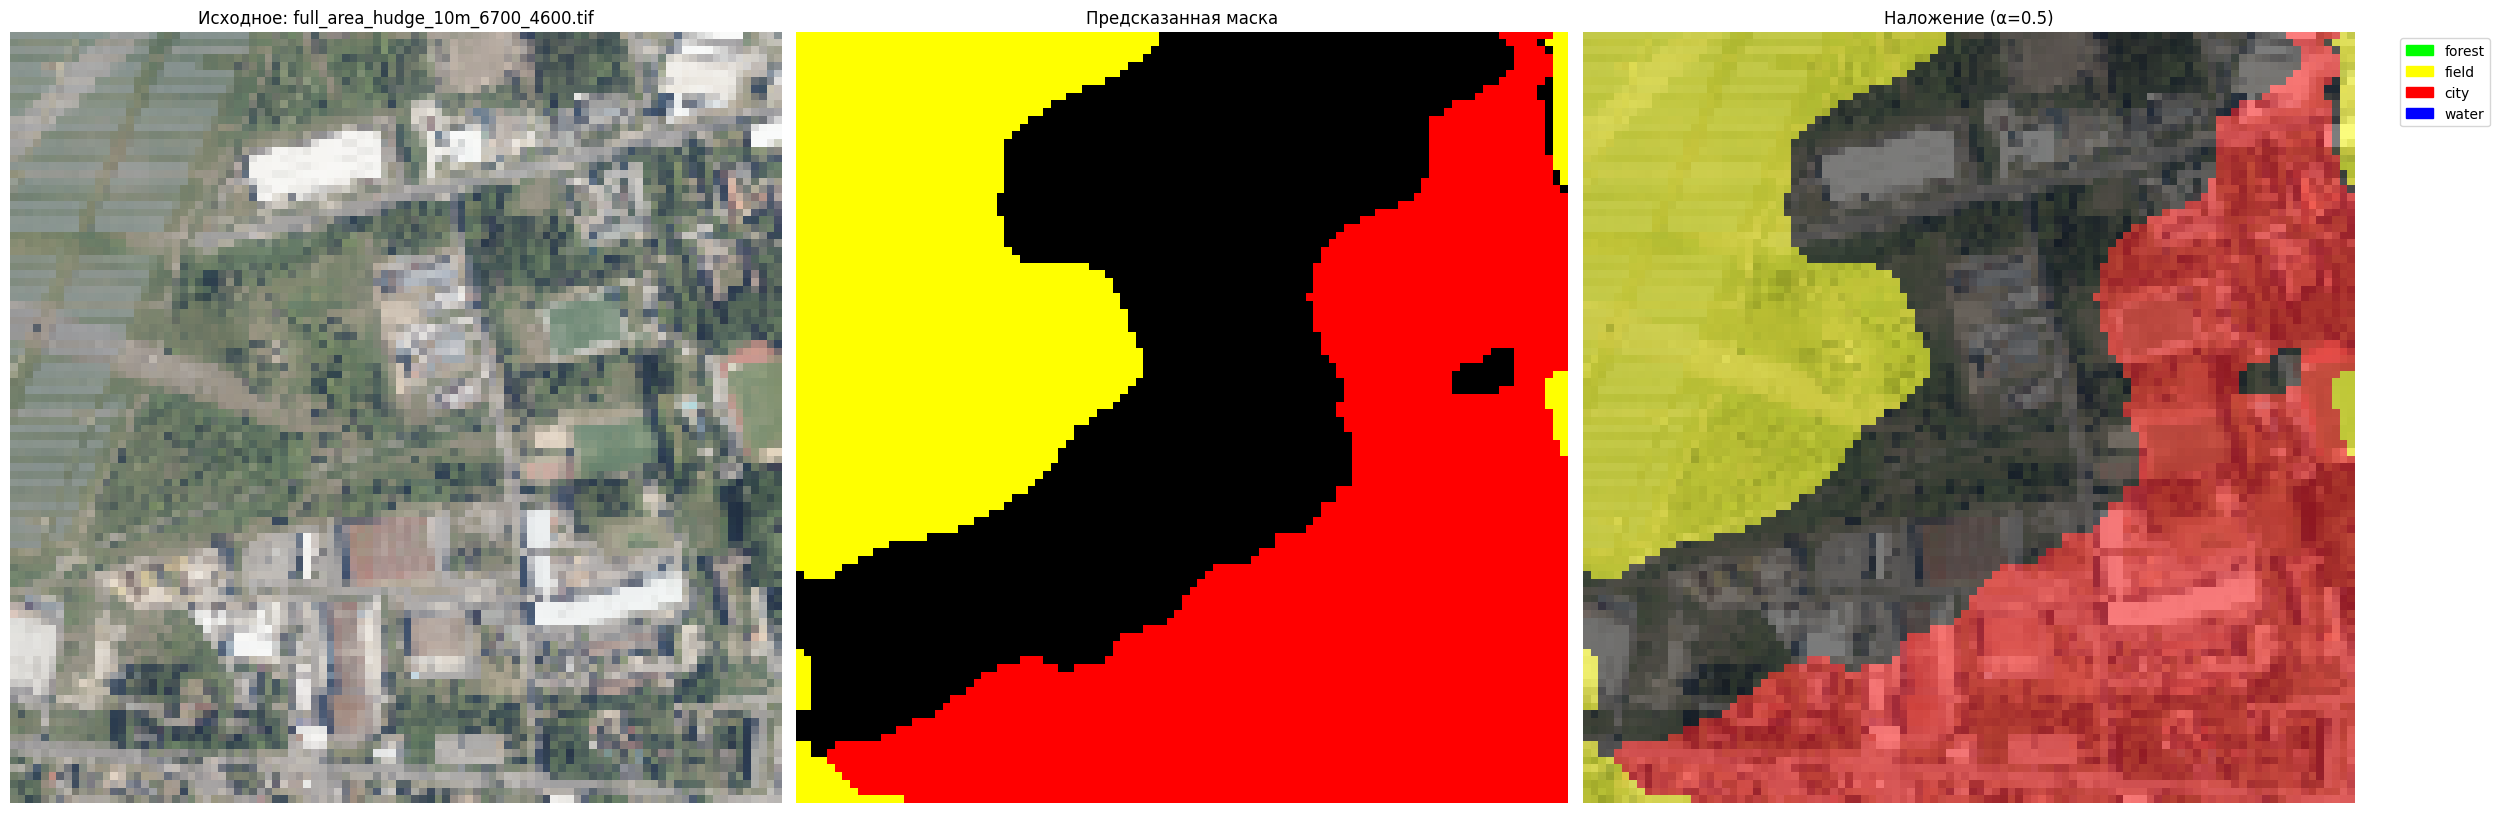


Файл: /content/drive/MyDrive/Цифровая кафедра/Сигментация/Полный архив/Город/full_area_hudge_10m_6700_4600.tif
background: 36.40%
field: 24.62%
city: 38.98%
--------------------------------------------------


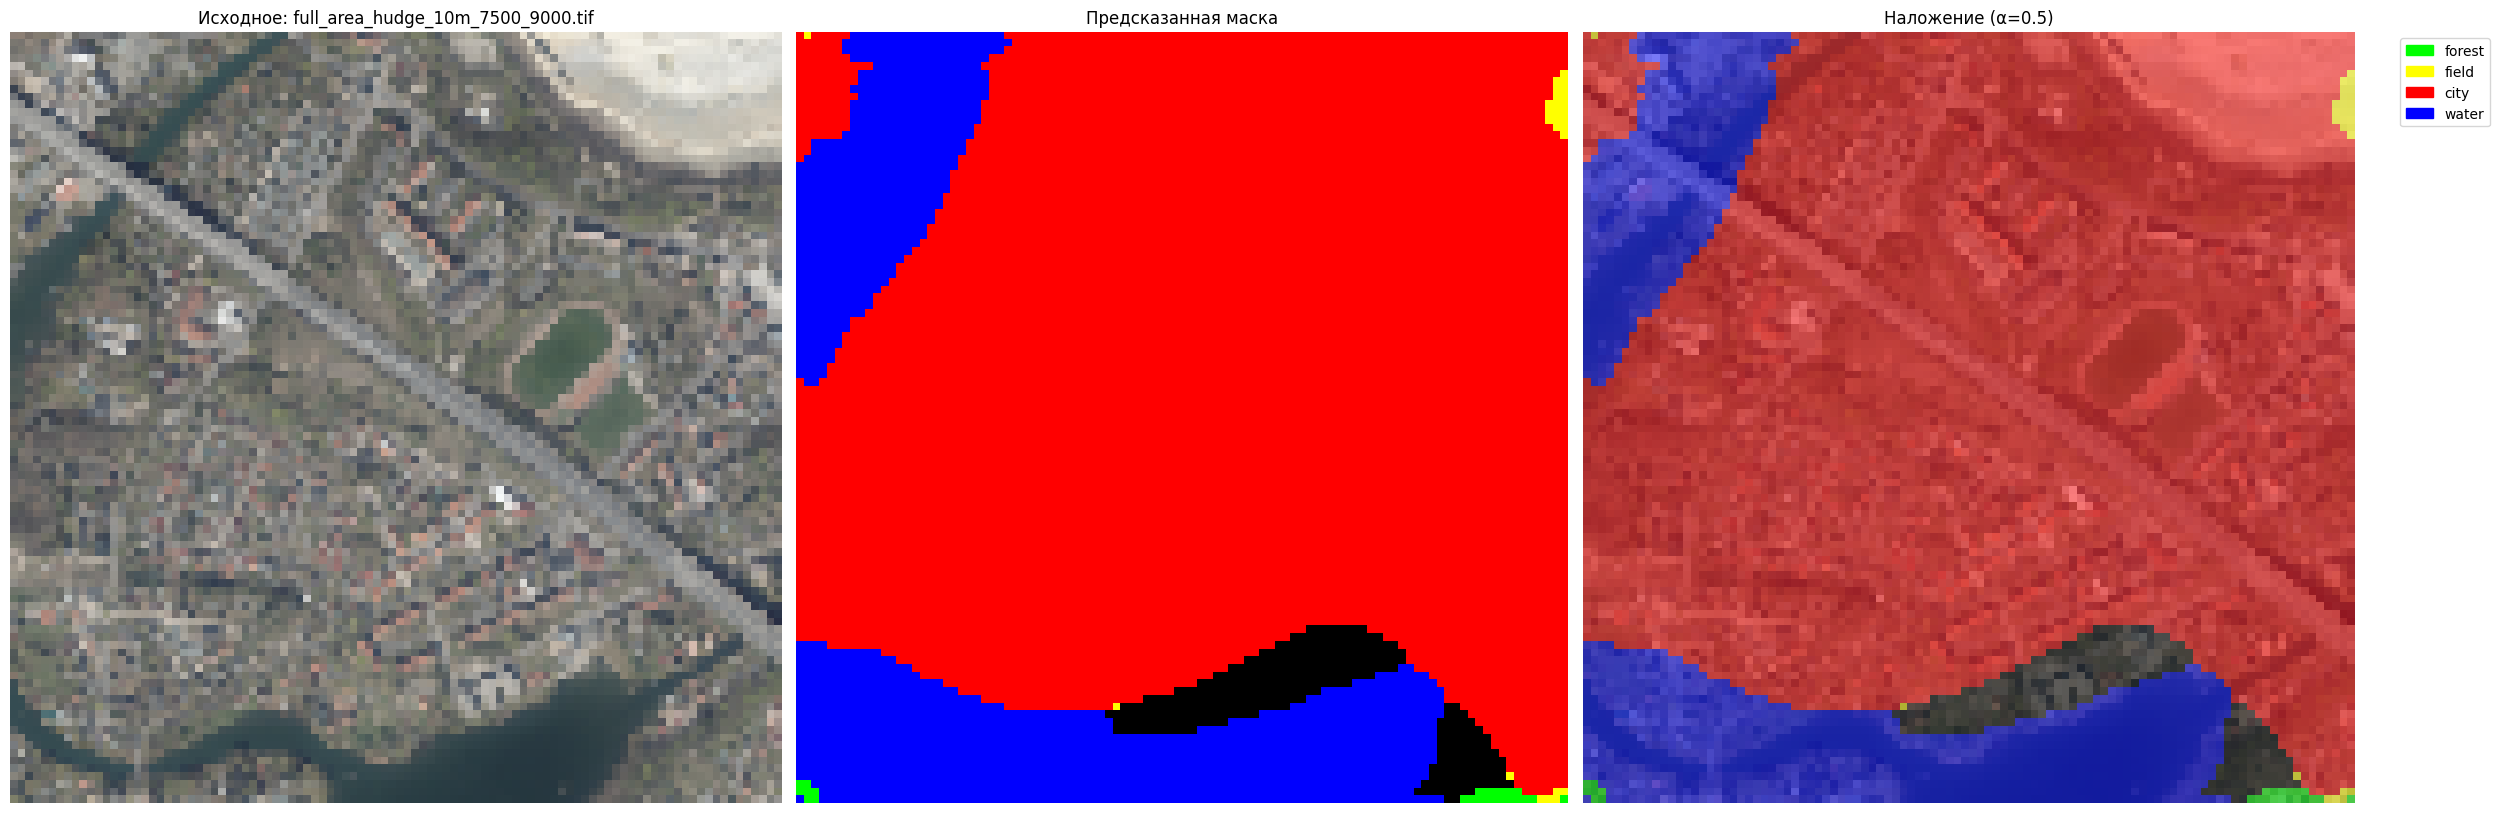


Файл: /content/drive/MyDrive/Цифровая кафедра/Сигментация/Полный архив/Город/full_area_hudge_10m_7500_9000.tif
background: 3.36%
forest: 0.24%
field: 0.27%
city: 77.85%
water: 18.28%
--------------------------------------------------


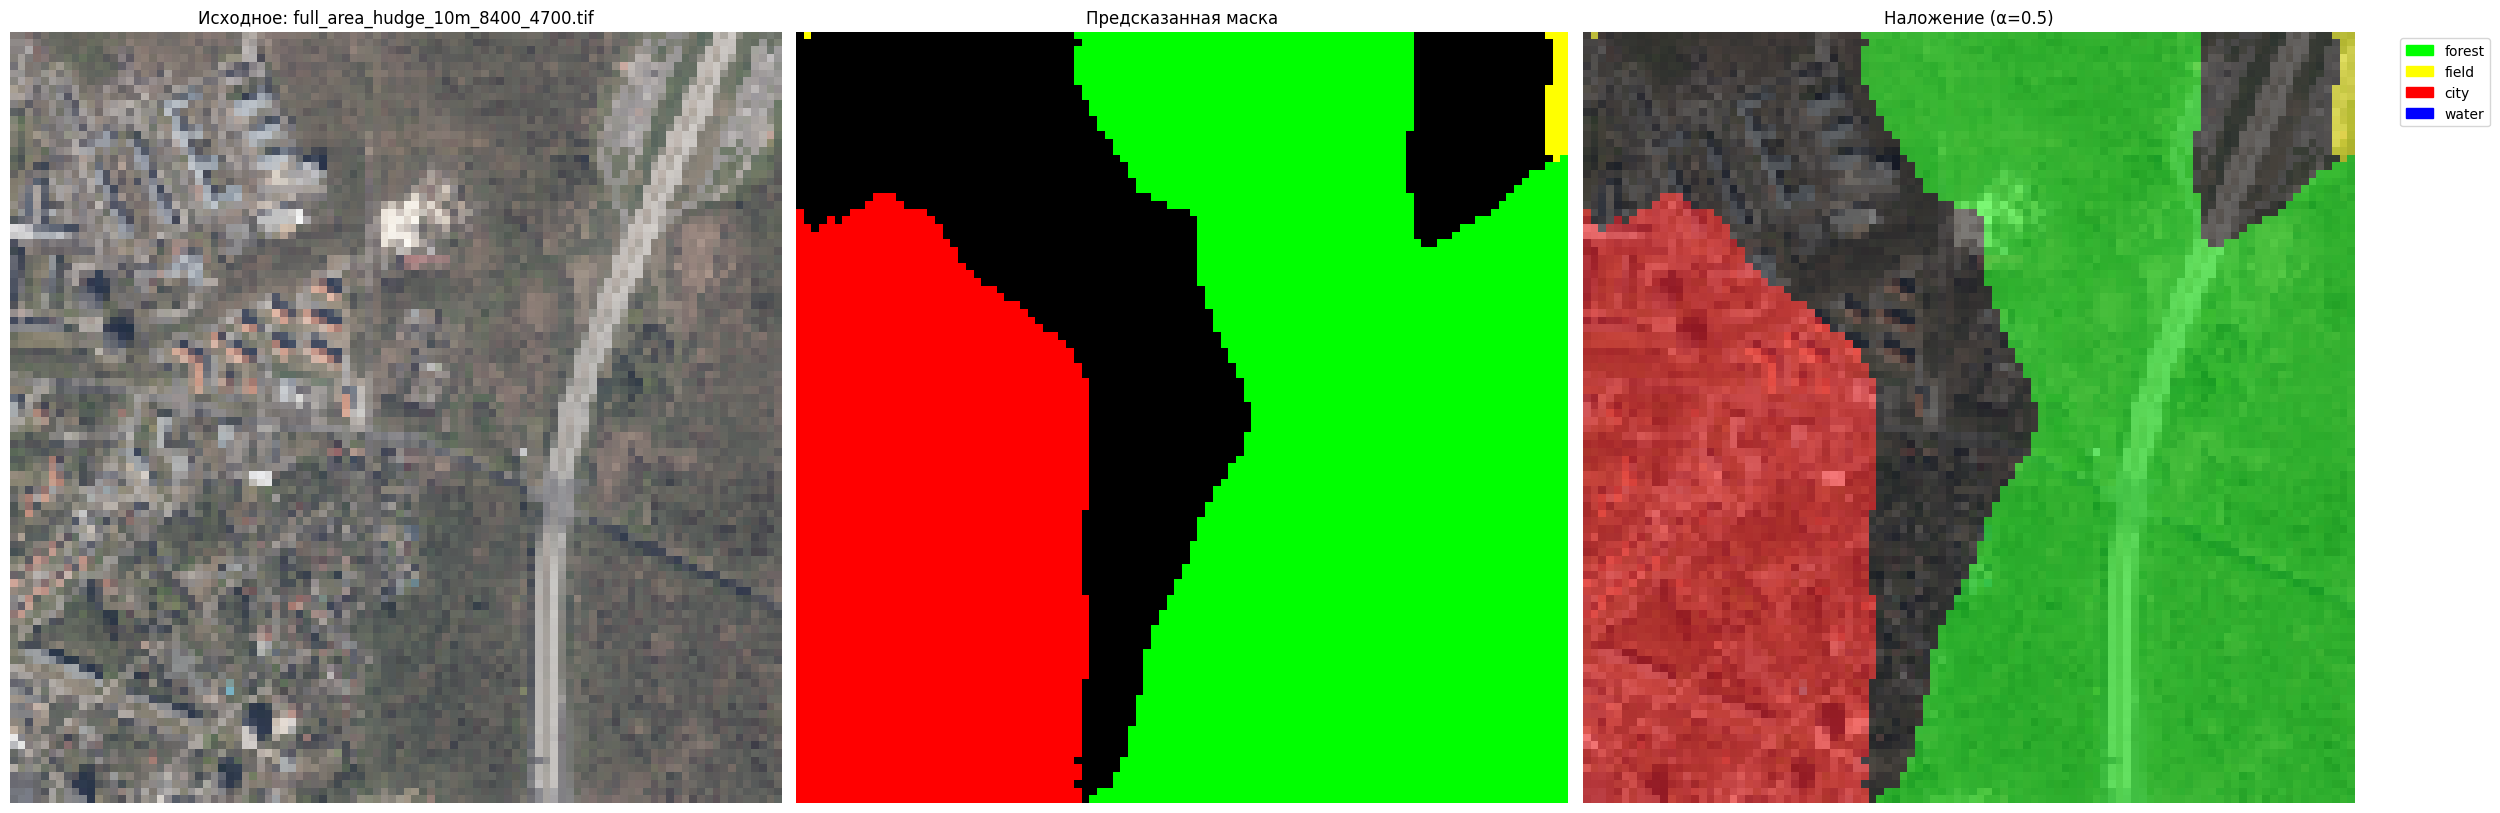


Файл: /content/drive/MyDrive/Цифровая кафедра/Сигментация/Полный архив/Город/full_area_hudge_10m_8400_4700.tif
background: 25.71%
forest: 47.33%
field: 0.44%
city: 26.52%
--------------------------------------------------


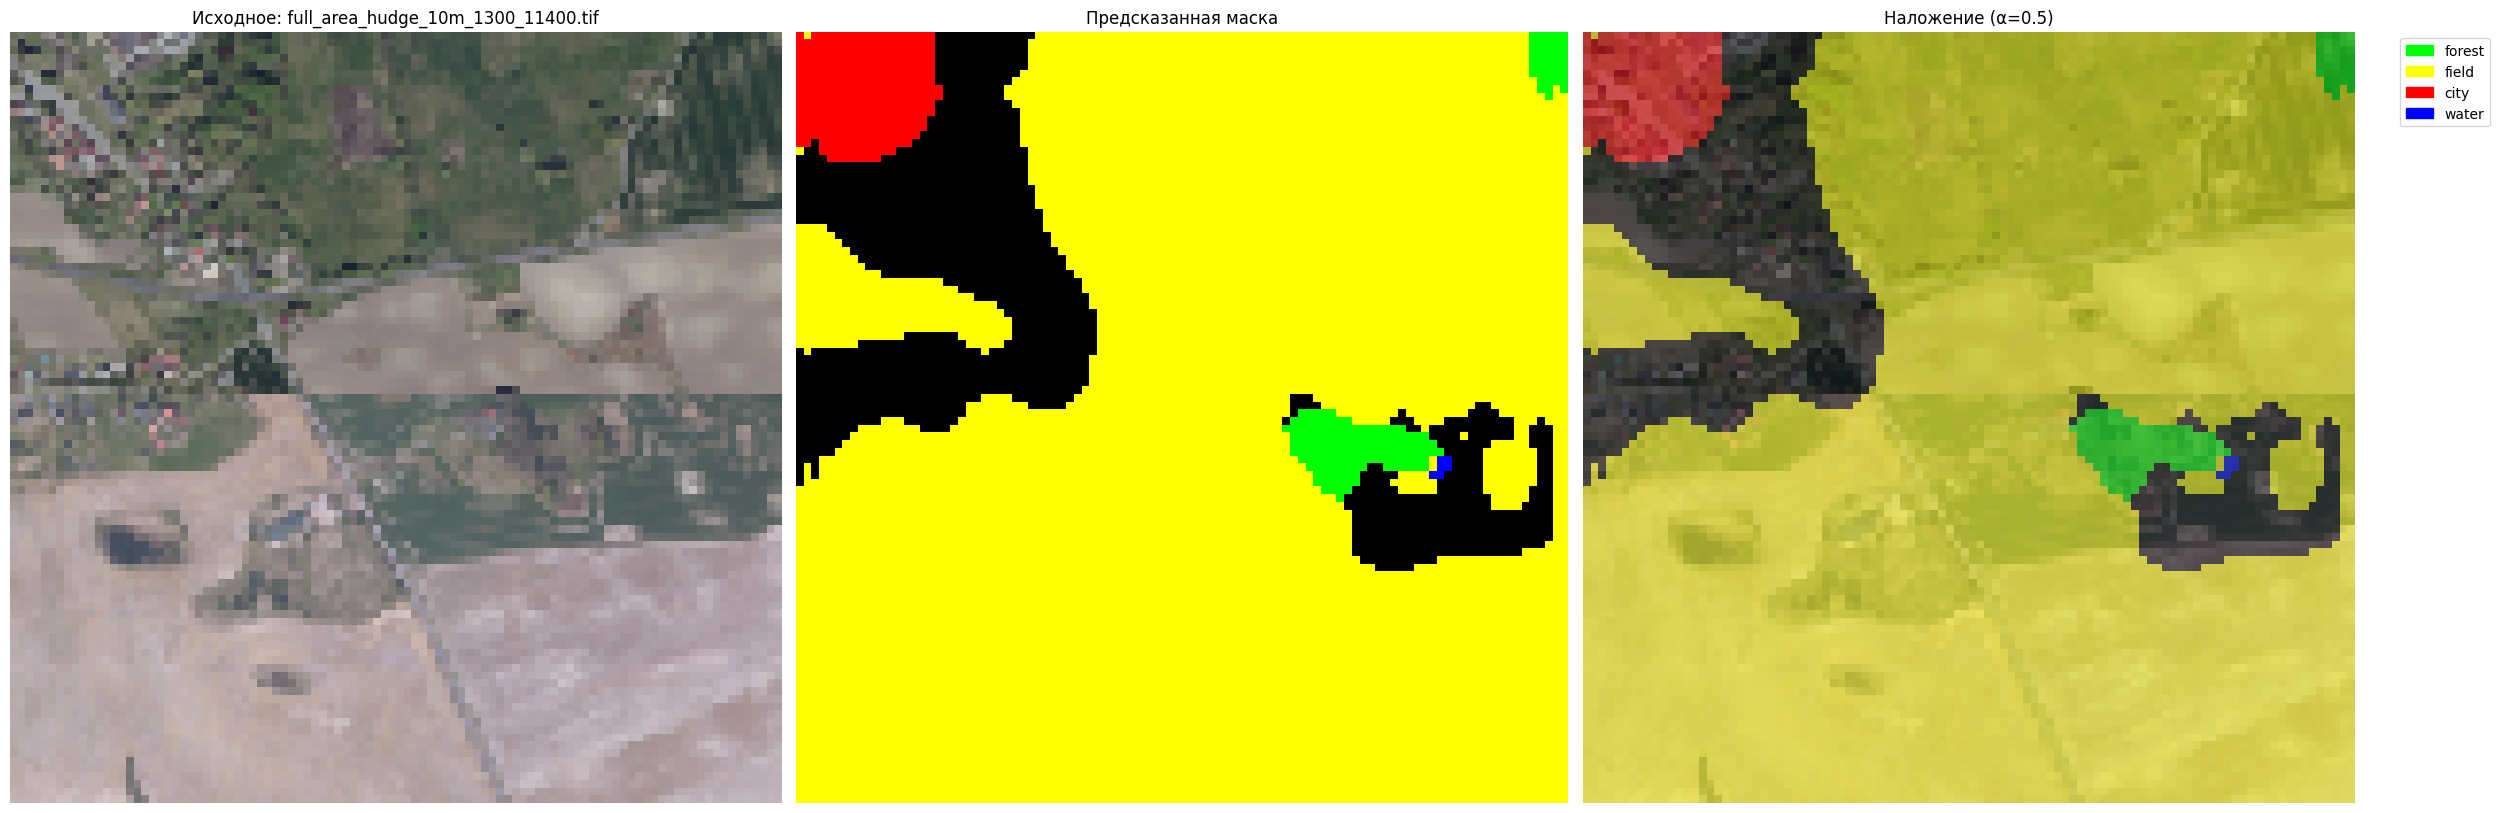


Файл: /content/drive/MyDrive/Цифровая кафедра/Сигментация/Полный архив/Город/full_area_hudge_10m_1300_11400.tif
background: 14.89%
forest: 1.72%
field: 80.53%
city: 2.80%
water: 0.06%
--------------------------------------------------


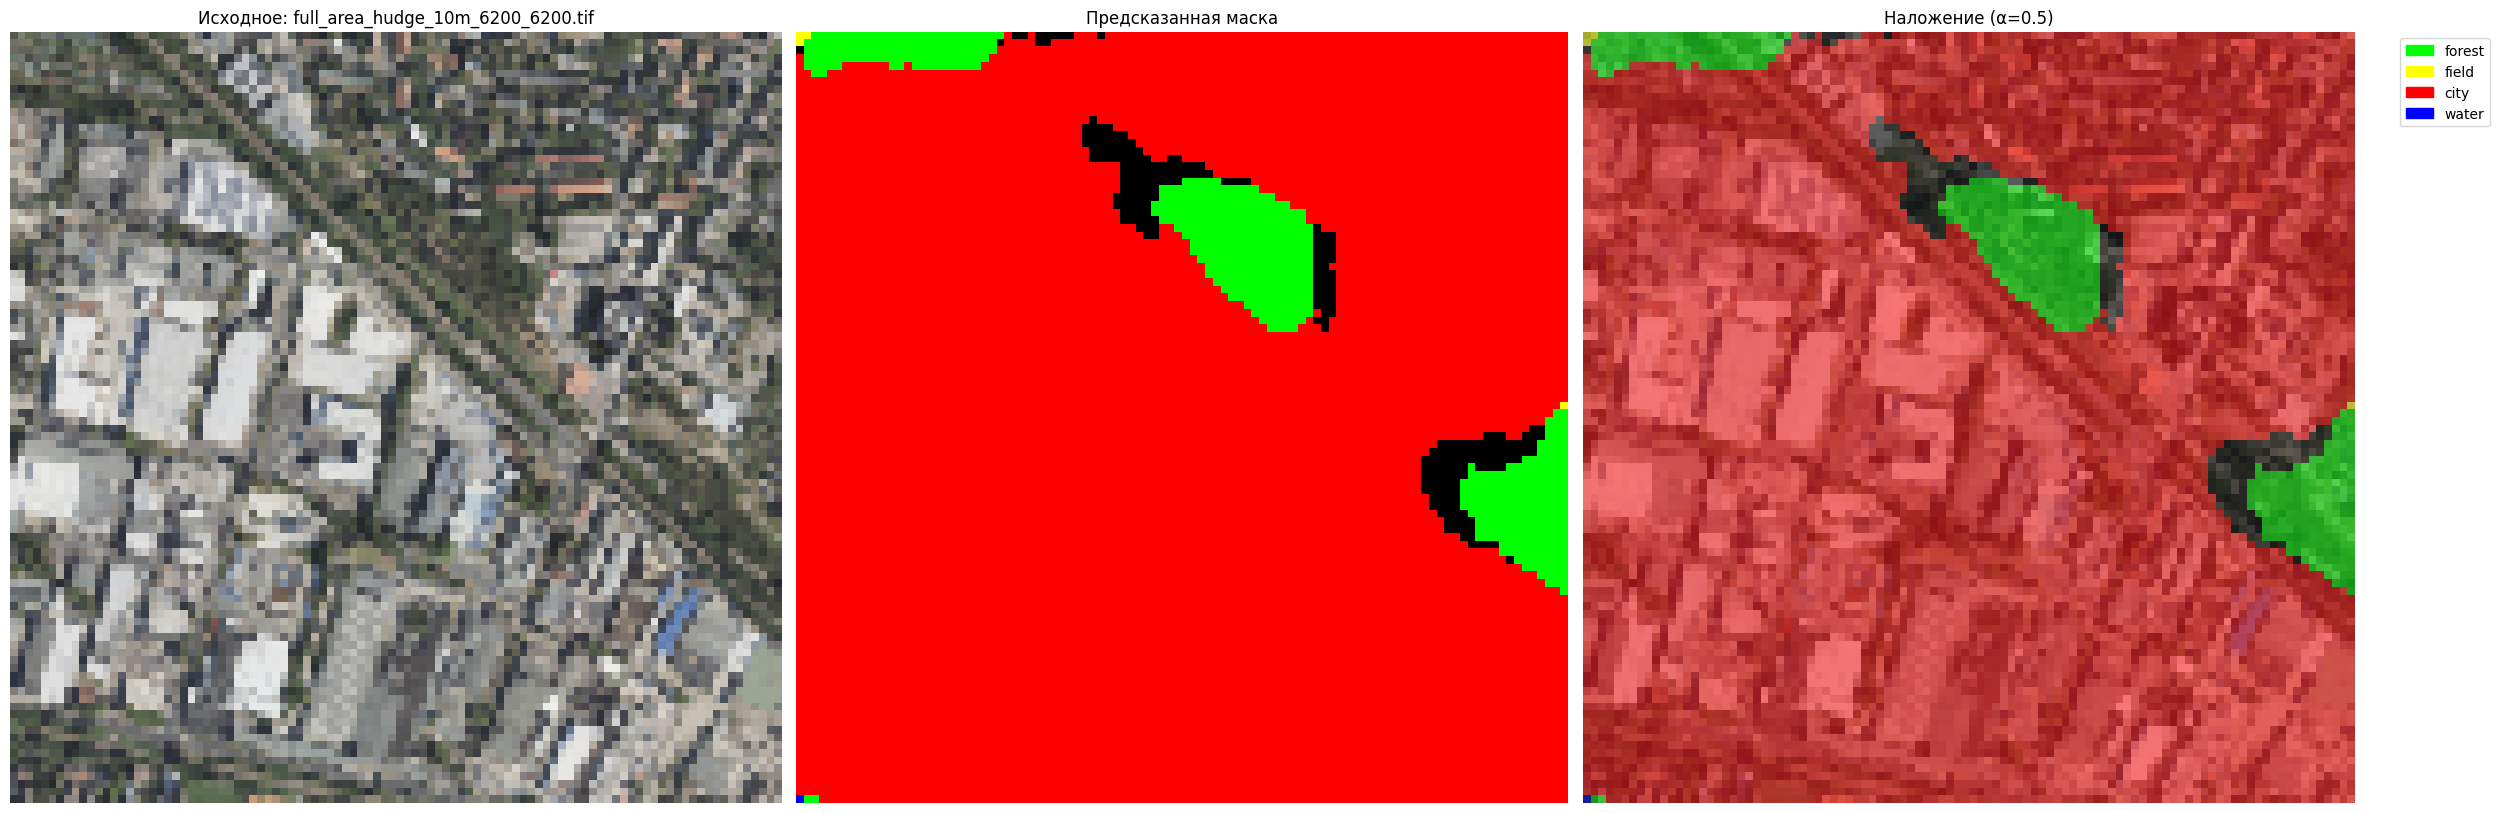


Файл: /content/drive/MyDrive/Цифровая кафедра/Сигментация/Полный архив/Город/full_area_hudge_10m_6200_6200.tif
background: 2.48%
forest: 5.73%
field: 0.04%
city: 91.74%
water: 0.01%
--------------------------------------------------


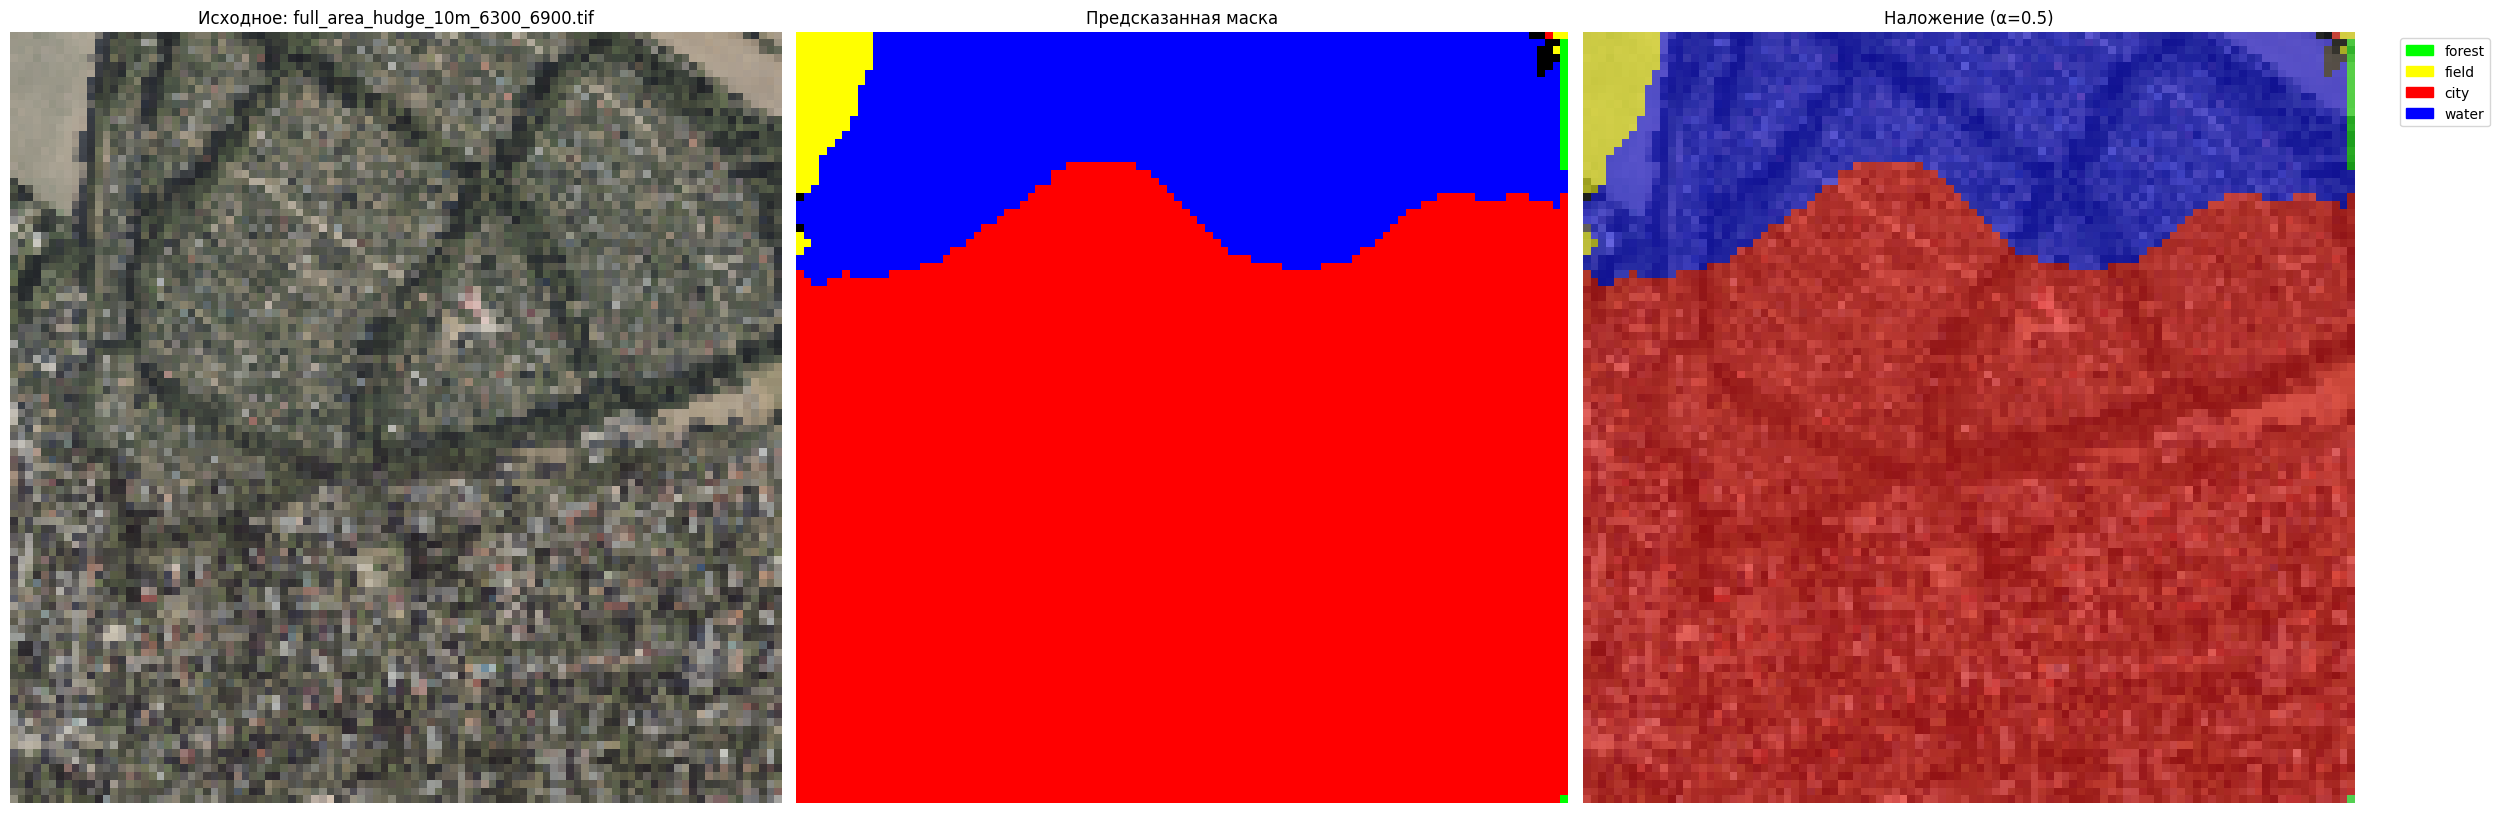


Файл: /content/drive/MyDrive/Цифровая кафедра/Сигментация/Полный архив/Город/full_area_hudge_10m_6300_6900.tif
background: 0.14%
forest: 0.18%
field: 1.50%
city: 74.76%
water: 23.42%
--------------------------------------------------


In [16]:
import torch
import torch.nn as nn
import segmentation_models_pytorch as smp
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import os
import glob
from google.colab import drive
from ipywidgets import widgets, interact
from IPython.display import display, clear_output
import albumentations as A
from albumentations.pytorch import ToTensorV2

# 1. Монтируем Google Drive и загружаем модель
drive.mount('/content/drive')

# Конфигурация классов и цветов
CLASSES = {
    0: 'background',
    1: 'forest',  # Было city
    2: 'field',
    3: 'city',    # Было forest
    4: 'water'
}

CLASS_COLORS = {
    1: [0, 255, 0],  # Зеленый для леса (был город)
    2: [255, 255, 0],
    3: [255, 0, 0],   # Красный для города (был лес)
    4: [0, 0, 255]
}

# Определяем архитектуру модели
class SegModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = smp.Unet(
            encoder_name="resnet34",
            encoder_weights=None,
            classes=len(CLASSES),
            activation='softmax'
        )

    def forward(self, x):
        return self.model(x)

# Загружаем сохраненную модель
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_path = '/content/drive/MyDrive/Цифровая кафедра/Сигментация/supervisely/models/best_model.pth'
model = SegModel().to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

# 2. Функция для интерактивной визуализации
def interactive_mask_predictor():
    base_path = '/content/drive/MyDrive/Цифровая кафедра/Сигментация/Полный архив/'
    categories = [d for d in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, d))]

    # Создаем элементы управления
    category_dropdown = widgets.Dropdown(
        options=categories,
        description='Категория:',
        style={'description_width': 'initial'}
    )

    image_slider = widgets.IntSlider(
        value=3,
        min=1,
        max=20,
        step=1,
        description='Количество:',
        style={'description_width': 'initial'}
    )

    alpha_slider = widgets.FloatSlider(
        value=0.5,
        min=0.1,
        max=1.0,
        step=0.1,
        description='Прозрачность:',
        style={'description_width': 'initial'}
    )

    random_toggle = widgets.ToggleButton(
        value=True,
        description='Случайный выбор'
    )

    show_grid = widgets.ToggleButton(
        value=False,
        description='Показать сетку'
    )

    run_button = widgets.Button(
        description="Запуск!",
        button_style='success',
        layout={'width': '200px'}
    )

    # Функция обработки
    def on_run(b):
        clear_output(wait=True)
        display(category_dropdown, image_slider, alpha_slider,
                widgets.HBox([random_toggle, show_grid]), run_button)

        category = category_dropdown.value
        num_images = image_slider.value
        alpha = alpha_slider.value

        # Получаем список изображений
        image_dir = os.path.join(base_path, category)
        images = glob.glob(os.path.join(image_dir, '*.png')) + \
                 glob.glob(os.path.join(image_dir, '*.jpg')) + \
                 glob.glob(os.path.join(image_dir, '*.tif'))

        if not images:
            print("Изображения не найдены!")
            return

        # Выбираем изображения
        selected = np.random.choice(images, num_images) if random_toggle.value else images[:num_images]

        # Обработка каждого изображения
        for img_path in selected:
            try:
                img = np.array(Image.open(img_path).convert('RGB'))
                h, w = img.shape[:2]

                # Разбиваем на тайлы и обрабатываем
                tile_size = 512
                mask = np.zeros((h, w), dtype=np.uint8)

                for y in range(0, h, tile_size):
                    for x in range(0, w, tile_size):
                        tile = img[y:y+tile_size, x:x+tile_size]
                        if tile.size == 0:
                            continue

                        # Преобразования
                        transform = A.Compose([
                            A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                            ToTensorV2()
                        ])
                        tensor = transform(image=tile)['image'].unsqueeze(0).to(device)

                        # Предсказание
                        with torch.no_grad():
                            pred = torch.argmax(model(tensor), dim=1).cpu().numpy()[0]
                            mask[y:y+tile.shape[0], x:x+tile.shape[1]] = pred

                # Создаем цветную маску
                color_mask = np.zeros((h, w, 3), dtype=np.uint8)
                for cls, color in CLASS_COLORS.items():
                    color_mask[mask == cls] = color

                # Визуализация
                fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(25, 10))

                # Оригинал
                ax1.imshow(img)
                ax1.set_title(f"Исходное: {os.path.basename(img_path)}")
                ax1.axis('off')

                # Маска
                ax2.imshow(color_mask)
                ax2.set_title("Предсказанная маска")
                ax2.axis('off')

                # Наложение
                ax3.imshow(img)
                ax3.imshow(color_mask, alpha=alpha)
                ax3.set_title(f"Наложение (α={alpha})")
                ax3.axis('off')

                # Легенда
                patches = [mpatches.Patch(color=np.array(c)/255, label=CLASSES[cls])
                          for cls, c in CLASS_COLORS.items()]
                plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left')

                plt.tight_layout()
                plt.show()

                # Статистика
                print(f"\nФайл: {img_path}")
                unique, counts = np.unique(mask, return_counts=True)
                for cls, cnt in zip(unique, counts):
                    print(f"{CLASSES[cls]}: {cnt/(h*w):.2%}")
                print("-"*50)

            except Exception as e:
                print(f"Ошибка обработки {img_path}: {str(e)}")

    run_button.on_click(on_run)

    # Отображаем элементы управления
    display(widgets.VBox([
        widgets.HBox([category_dropdown, image_slider]),
        widgets.HBox([alpha_slider]),
        widgets.HBox([random_toggle, show_grid]),
        run_button
    ]))

# Запускаем интерактивную визуализацию
print("Модель загружена. Выберите параметры и нажмите 'Запуск!'")
interactive_mask_predictor()